# Set up

In [4]:
import os
import sys

module_path = os.path.abspath(os.path.join('../src/'))
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)

/Volumes/GoogleDrive/My Drive/USC/Projects/210913-FiberNET/211025-Exp3-ConvVAE/src


In [5]:
import glob
import random
import pickle
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from tqdm.auto import tqdm
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter

import dipy
from dipy.viz import window, actor

from data.SubjData import *
from data.data_util import *
from utils.general_util import *
from model.model import *
from evaluation import *

In [6]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.
GPU is not enabled in this notebook.


In [7]:
model_folder = "../../results/models/"
plot_folder = "../../results/plots/"
result_data_folder = "../../results/data/"
log_folder = "../../results/logs/"
data_files_folder = "../../data_files/"


# change these if running locally
data_folder = "../../../211105-ADNI3_DWI_data/"

# Inference

CN1: 007_S_6120_20171117_A3_DWI_S127  
CN2: 002_S_6680_20190404_A3_DWI_S127  
MCI: 023_S_6702_20190312_A3_DWI_S127  
AD : 023_S_1190_20190225_A3_DWI_S127

In [11]:
df_meta = pd.read_csv(data_files_folder + "metadata_inference_acc.csv")
print(df_meta.shape)
df_meta.head()

(140, 49)


,Subject,SubjID_base,Sex,Age,DX,PTEDUCAT,PTRACCAT,CDRSB,ADAS11,ADAS13,...,MdLF_R_acc,OPT_L_acc,OPT_R_acc,OR_L_acc,OR_R_acc,STT_L_acc,STT_R_acc,UF_L_acc,UF_R_acc,V_acc
0,002_S_0413_20190827_A3_DWI_S127,002_S_0413,F,89.6550,CN,16,White,0.0,9.00,11.00,...,0.941111,1.000000,1.000000,0.582231,0.516129,0.725076,1.000000,1.000000,NaN,NaN
1,002_S_1280_20190306_A3_DWI_S127,002_S_1280,F,82.8084,CN,14,White,0.0,10.33,15.33,...,0.781250,0.822115,0.875479,0.710616,0.539291,0.783784,1.000000,NaN,NaN,NaN
2,002_S_4213_20191003_A3_DWI_S127,002_S_4213,F,86.1259,CN,14,White,0.0,9.00,10.00,...,0.847400,1.000000,0.980080,0.956989,1.000000,0.693481,0.556416,0.589649,1.0,1.0
3,002_S_6009_20190520_A3_DWI_S127,002_S_6009,M,69.6523,CN,16,White,0.0,6.00,9.00,...,NaN,0.379487,0.915888,0.959375,0.677047,0.271268,0.753333,1.000000,1.0,NaN
4,002_S_6030_20190916_A3_DWI_S127,002_S_6030,F,67.4079,CN,18,White,0.0,7.00,10.00,...,0.783566,0.828571,0.830362,0.948478,0.995016,0.691120,0.504478,0.663265,1.0,1.0


## Run script

ONLY RUN THIS IN CLUSTER

In [ ]:
subj_train = '007_S_6120_20171117_A3_DWI_S127'
model_setting = 'convVAE3L_XUXU_Z2_B128_LR2E-04_WD1E-03_GCN2E+00' 
epoch = 400

model_subfolder = f"{model_setting}_{subj_train}"
subj_infer = "002_S_6680_20190404_A3_DWI_S127"
print(model_subfolder)

In [ ]:
df_info[df_info.Subject==subj_infer]

In [ ]:
!python ../src/inference.py --model_name {model_subfolder} \
                            --epoch {epoch} \
                            --seed {SEED} \
                            --subj {subj_infer} \
                            --device {DEVICE} \
                            --data_folder {data_folder} \
                            --model_folder {model_folder} \
                            --result_data_folder {result_data_folder}

## Load Model

In [12]:
subj_train = '007_S_6120_20171117_A3_DWI_S127'
model_setting = 'convVAE3L_XUXU_Z2_B128_LR2E-04_WD1E-03_GCN2E+00'
epoch = 400
model_subfolder = f"{model_setting}_{subj_train}"
print(model_subfolder)

convVAE3L_XUXU_Z2_B128_LR2E-04_WD1E-03_GCN2E+00_007_S_6120_20171117_A3_DWI_S127


In [13]:
model_info = parse_model_setting(model_setting)
model = init_model(model_type=model_info['model_type'], 
                        Z=model_info['Z'])
model.load_state_dict(torch.load(f"{model_folder}{model_subfolder}/model_E{epoch}", 
                                 map_location=torch.device(DEVICE)))
model.eval()
print("# model params: ", sum(p.numel() for p in model.parameters()))

Random seed 2021 has been set.
# model params:  1641326


## Load Inference

In [18]:
def load_inference(subj_name, model_subfolder, epoch):
    
    n_points = 256 # numbers of points per streamline
    n_lines = None # number of streamlines to load (CST: 1375; ILF: 1015; IFOF: 209)
    preprocess = "3d"
    rng = np.random.RandomState(SEED)
    min_lines = 2
    mean = torch.tensor([1.1069, -23.8073,  13.3312])
    std = torch.tensor([25.0185, 28.6887, 23.8379])
    

    subj = load_subject(subj_name,
                        n_points=n_points, n_lines=n_lines,
                        preprocess=preprocess, rng=rng,
                        min_lines=min_lines,
                        data_folder=data_folder,verbose=False)
    
    result = load_pickle(f"{result_data_folder}{model_subfolder}/E{epoch}_{subj_name}")
    subj.update(result)
    subj['X_norm'] = torch.from_numpy(subj['X']).sub(mean).div(std)
    
    return subj

In [21]:
# %%time
subj_cn1 = load_inference('007_S_6120_20171117_A3_DWI_S127', model_subfolder, epoch)
subj_cn2 = load_inference('002_S_6680_20190404_A3_DWI_S127', model_subfolder, epoch)
subj_mci = load_inference('023_S_6702_20190312_A3_DWI_S127', model_subfolder, epoch)
subj_ad = load_inference('023_S_1190_20190225_A3_DWI_S127', model_subfolder, epoch)

Loaded 007_S_6120_20171117_A3_DWI_S127 with 32 tracts and 51654 lines.
Loaded 002_S_6680_20190404_A3_DWI_S127 with 32 tracts and 35295 lines.
Loaded 023_S_6702_20190312_A3_DWI_S127 with 32 tracts and 34621 lines.
Loaded 023_S_1190_20190225_A3_DWI_S127 with 31 tracts and 30069 lines.


# Evaluate Embeddings

## Embedding Distance

In [23]:
'''Compute Distance'''

def get_centroid(points):
    return np.median(points,axis=0)
    
def centroid_dist(points_A, points_B):
    return np.linalg.norm(get_centroid(points_A) - get_centroid(points_B))    

def compute_distmat(subj1, subj2, label1, label2, plot_mat=True):
    dist_mat = np.zeros((len(subj1['bundle_idx']),
                         len(subj2['bundle_idx'])))

    for i, (name1, idx1) in enumerate(subj1['bundle_idx'].items()):
        for j, (name2, idx2) in enumerate(subj2['bundle_idx'].items()):
            dist_mat[i][j] = centroid_dist(subj1['X_encoded'][idx1], 
                                           subj2['X_encoded'][idx2])
    
    if plot_mat:
        mask = np.ones_like(dist_mat, dtype=bool)
        mask[np.tril_indices_from(mask)] = False
        
        fig, ax = plt.subplots(figsize=(10,10))
        sns.heatmap(dist_mat, mask=mask, square=True, 
                    linewidth=.5, cmap='YlGnBu', ax=ax)

        ax.set_yticklabels(subj1['bundle_idx'].keys(),rotation=0)
        ax.set_xticklabels(subj2['bundle_idx'].keys(),rotation=90)
        ax.set_ylabel(label1)
        ax.set_xlabel(label2)
        
    print(dist_mat.shape)
        
    return dist_mat

(32, 32)


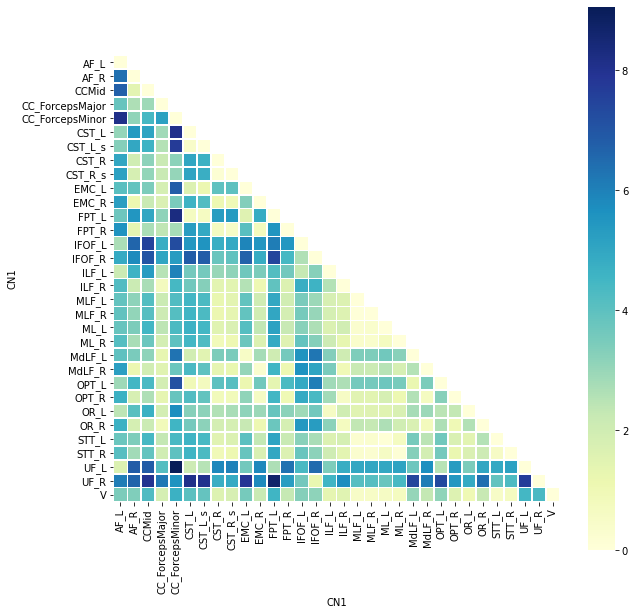

In [12]:
_ = compute_distmat(subj_cn1, subj_cn1, 'CN1', 'CN1')

(32, 31)


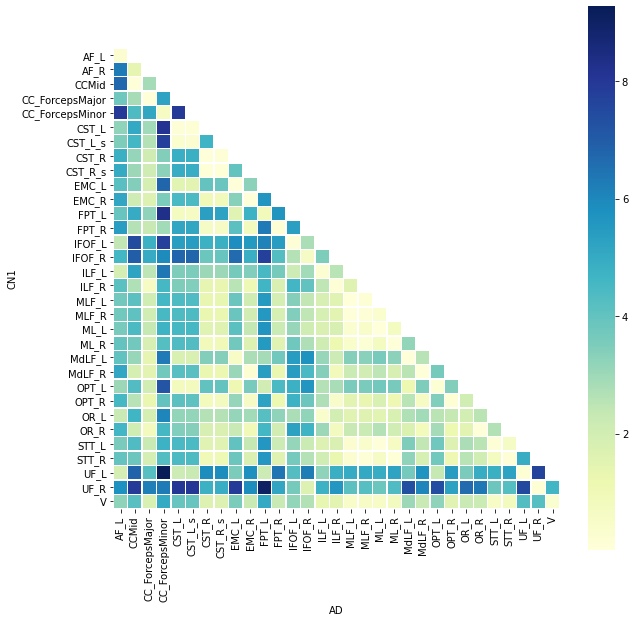

In [13]:
# _ = compute_distmat(subj_cn1, subj_cn2, 'CN1', 'CN2')
# _ = compute_distmat(subj_cn1, subj_mci, 'CN1', 'MCI')
_ = compute_distmat(subj_cn1, subj_ad, 'CN1', 'AD')

## Plot Embeddings by Bundle

In [28]:
def _plot_embedding(embeddings, y, palette, label='CN'):
    '''Plot 2D embedding (first 2 dimensions)'''

    fig, ax = plt.subplots(1, figsize=(10, 10))
    df_vis = pd.DataFrame({'dim1': embeddings[:, 0], 'dim2': embeddings[:, 1],
                           'label': y})
    exclude_bundles = ['CST_L_s','CST_R_s']
    df_vis = df_vis[~df_vis.label.isin(exclude_bundles)]
    g=sns.scatterplot(x='dim1', y='dim2', hue='label', 
                      palette=palette, data=df_vis, ax=ax, s=12)
    ax.set_title(f"ConvVAE Embeddings ({label})", fontsize=18)
    ax.set_xlabel('dim1', fontsize=16)
    ax.set_ylabel('dim2', fontsize=16)
    g.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)


def plot_embedding(subj, palette, label='CN', use_TSNE=False):
    subj_data = load_inference(subj, model_subfolder, epoch)
    if use_TSNE:
        _plot_embedding(subj_data['X_encoded_tsne'], 
                        map_list_with_dict(subj_data['y'],subj_data['bundle_num']),
                        palette,
                        label=label)
    else:
        _plot_embedding(subj_data['X_encoded'], 
                        map_list_with_dict(subj_data['y'],subj_data['bundle_num']),
                        palette,
                        label=label)

In [29]:
# gist_ncar, nipy_spectral, hsv
cmap = make_color_map('nipy_spectral', 
                      subj_cn1['bundle_count'].keys(),
                      plot_cmap=False)

Loaded 023_S_6702_20190312_A3_DWI_S127 with 32 tracts and 34621 lines.


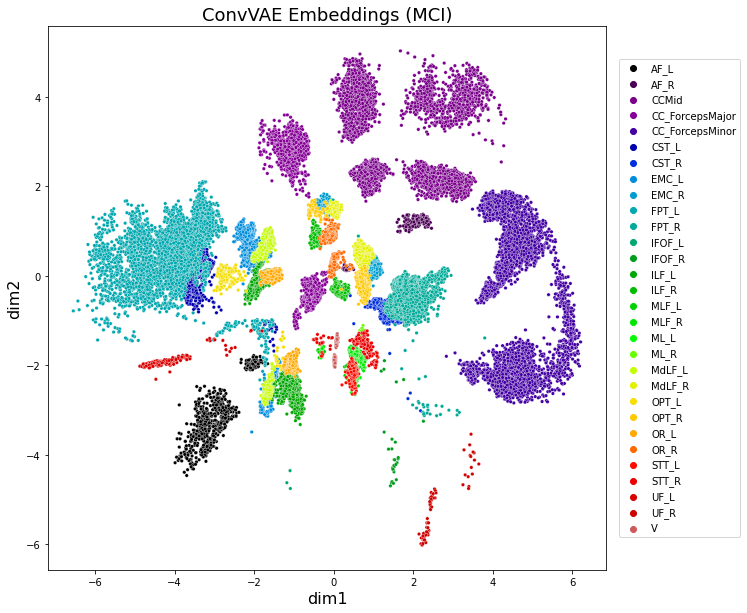

In [31]:
'''Plot all bundle embeddings for one subjects'''
plot_embedding("023_S_6702_20190312_A3_DWI_S127", cmap, label='MCI', use_TSNE=False)

Text(0, 0.5, 'dim2')

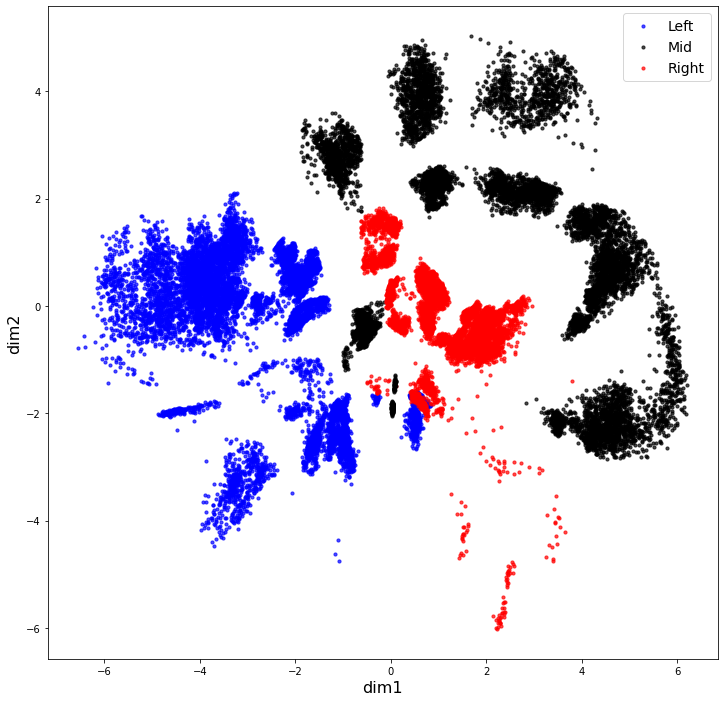

In [32]:
'''Plot bundle embeddings of one subject by left/right'''

bundles = subj_ad['bundle_count'].keys()
# subj_label="mci"
subj=subj_mci

color_list = mpl.cm.datad['tab20']['listed']
s = 10
alpha = 0.7

fig, ax = plt.subplots(figsize=(12,12))


for i, bundle in enumerate(bundles):
    if bundle.endswith("_s"):
        continue
    if '_L' in bundle:
        c='b'
        label='Left'
    elif '_R' in bundle:
        c='r'
        label='Right'
    else:
        c='k'
        label='Mid'
    data = subj['X_encoded'][subj['bundle_idx'][bundle]]
    ax.scatter(data[:,0], data[:,1], 
               color=c, s=s, alpha=alpha,
               label=f"{label}"
              )
#     centroid = get_centroid(data)
#     plt.plot(centroid[0],centroid[1],'ro', markersize=12, markeredgecolor='k',
#              color=c) 

handles, labels = ax.get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
ax.legend(handles, labels, loc='best',prop={'size': 14})

# ax.set_title(f"ConvVAE Embeddings ({subj_label}) by hemiphere", fontsize=18)
ax.set_xlabel('dim1', fontsize=16)
ax.set_ylabel('dim2', fontsize=16)

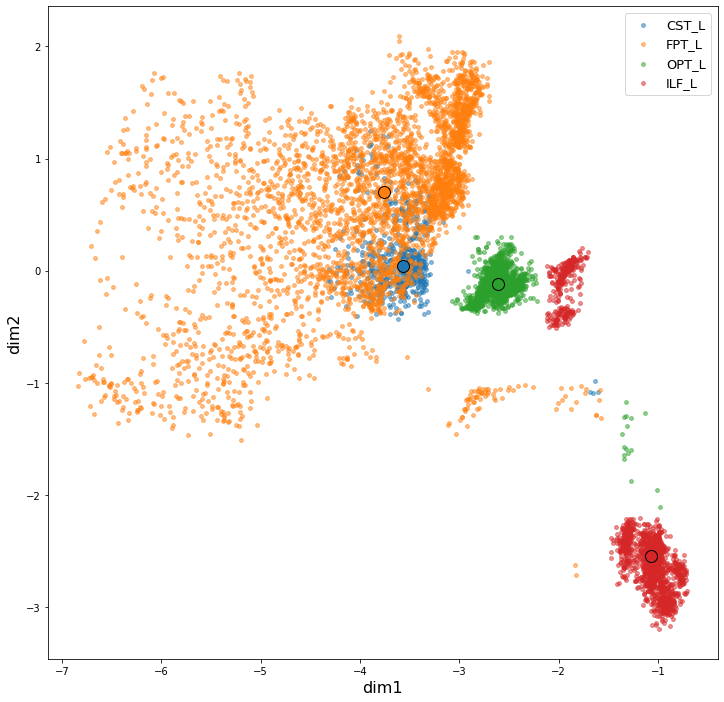

In [26]:
'''Plot selected bundles for one subject'''
bundles = ['CST_L','FPT_L','OPT_L','ILF_L']
color_list = mpl.cm.datad['tab10']['listed']
s = 15
alpha = 0.5
subj = subj_cn1
fig, ax = plt.subplots(figsize=(12,12))

for i, bundle in enumerate(bundles):
    data = subj['X_encoded'][subj['bundle_idx'][bundle]]
    ax.scatter(data[:,0], data[:,1], 
               color=color_list[i], s=s, alpha=alpha,
               label=f"{bundle}")
    centroid = get_centroid(data)
    plt.plot(centroid[0],centroid[1],'ro', markersize=12, markeredgecolor='k',
             color=color_list[i]) 
ax.set_xlabel('dim1', fontsize=16)
ax.set_ylabel('dim2', fontsize=16)
ax.legend(prop={'size': 13})
plt.savefig(plot_folder + "/cn_4bundle_embedding.png")

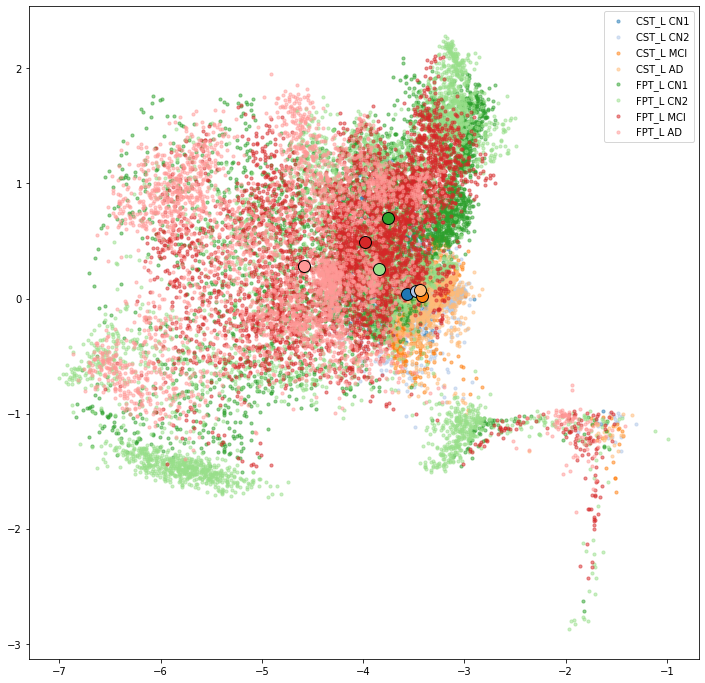

In [56]:
'''Compare pair of bundles between multiple subject'''

bundle_name1 = 'CST_L'
bundle_name2 = 'FPT_L'
color_list = mpl.cm.datad['tab20']['listed']
s = 10
alpha = 0.5
labels = ['CN1','CN2','MCI','AD']

fig, ax = plt.subplots(figsize=(12,12))
for i, subj in enumerate([subj_cn1, subj_cn2, subj_mci, subj_ad]):
    data = subj['X_encoded'][subj['bundle_idx'][bundle_name1]]
    ax.scatter(data[:,0], data[:,1], 
               color=color_list[i], s=s, alpha=alpha,
               label=f"{bundle_name1} {labels[i]}")
    centroid = get_centroid(data)
    plt.plot(centroid[0],centroid[1],'ro', markersize=12, markeredgecolor='k',
             color=color_list[i]) 

for i, subj in enumerate([subj_cn1, subj_cn2, subj_mci, subj_ad]):
    data = subj['X_encoded'][subj['bundle_idx'][bundle_name2]]
    ax.scatter(data[:,0], data[:,1], 
               color=color_list[i+4], s=s, alpha=alpha,
               label=f"{bundle_name2} {labels[i]}")
    centroid = get_centroid(data)
    plt.plot(centroid[0],centroid[1],'ro', markersize=12, markeredgecolor='k',
             color=color_list[i+4]) 
    
# ax.set_xlim([1,2.5])
# ax.set_ylim([-0.75,1])

ax.legend()

##  Plot Bundle Centroids

In [358]:
'''Save centroid position for each bundle'''
for subj in df_meta.Subject.values:
    subj_data = load_inference(subj, model_subfolder, epoch)
    for bundle in subj_cn1['bundle_count'].keys():
        if bundle not in subj_data['bundle_idx']:
            df_meta.at[df_meta.Subject==subj, f'{bundle}_X1'] = np.nan
            df_meta.at[df_meta.Subject==subj, f'{bundle}_X2'] = np.nan
        else:
            bundle_data = subj_data['X_encoded'][subj_data['bundle_idx'][bundle]]
            centroid = get_centroid(bundle_data)
            df_meta.at[df_meta.Subject==subj, f'{bundle}_X1'] = centroid[0]
            df_meta.at[df_meta.Subject==subj, f'{bundle}_X2'] = centroid[1]
# df_meta.to_csv(f"{data_files_folder}metadata_inference_centroid.csv", index=False)

Loaded 002_S_0413_20190827_A3_DWI_S127 with 30 tracts and 21421 lines.
Loaded 002_S_1280_20190306_A3_DWI_S127 with 28 tracts and 12032 lines.
Loaded 002_S_4213_20191003_A3_DWI_S127 with 32 tracts and 26093 lines.
Loaded 002_S_6009_20190520_A3_DWI_S127 with 30 tracts and 33001 lines.
Loaded 002_S_6030_20190916_A3_DWI_S127 with 32 tracts and 43435 lines.
Loaded 002_S_6053_20191105_A3_DWI_S127 with 31 tracts and 30773 lines.
Loaded 002_S_6066_20191111_A3_DWI_S127 with 31 tracts and 26055 lines.
Loaded 002_S_6680_20190404_A3_DWI_S127 with 32 tracts and 35295 lines.
Loaded 007_S_1222_20180117_A3_DWI_S127 with 31 tracts and 18720 lines.
Loaded 007_S_4387_20171101_A3_DWI_S127 with 32 tracts and 28006 lines.
Loaded 007_S_4488_20170912_A3_DWI_S127 with 31 tracts and 35087 lines.
Loaded 007_S_4620_20171205_A3_DWI_S127 with 30 tracts and 23916 lines.
Loaded 007_S_4637_20171010_A3_DWI_S127 with 30 tracts and 22384 lines.
Loaded 007_S_5265_20170918_A3_DWI_S127 with 31 tracts and 22859 lines.
Loaded

Loaded 067_S_0059_20171220_A3_DWI_S127 with 32 tracts and 31379 lines.
Loaded 067_S_6474_20180627_A3_DWI_S127 with 29 tracts and 34612 lines.
Loaded 067_S_6525_20190605_A3_DWI_S127 with 32 tracts and 39921 lines.
Loaded 067_S_6529_20180814_A3_DWI_S127 with 31 tracts and 43086 lines.
Loaded 128_S_4742_20180821_A3_DWI_S127 with 29 tracts and 18336 lines.
Loaded 341_S_6605_20181017_A3_DWI_S127 with 30 tracts and 34366 lines.
Loaded 341_S_6686_20190220_A3_DWI_S127 with 30 tracts and 26314 lines.
Loaded 341_S_6764_20190716_A3_DWI_S127 with 31 tracts and 29888 lines.
Loaded 941_S_4036_20181120_A3_DWI_S127 with 28 tracts and 36038 lines.
Loaded 941_S_4100_20181119_A3_DWI_S127 with 20 tracts and 9904 lines.
Loaded 941_S_6052_20180706_A3_DWI_S127 with 19 tracts and 11533 lines.
Loaded 941_S_6068_20180817_A3_DWI_S127 with 30 tracts and 24987 lines.
Loaded 941_S_6345_20180510_A3_DWI_S127 with 30 tracts and 24715 lines.
Loaded 941_S_6392_20180530_A3_DWI_S127 with 31 tracts and 31811 lines.
Loaded 

In [360]:
df_meta.shape

(140, 81)

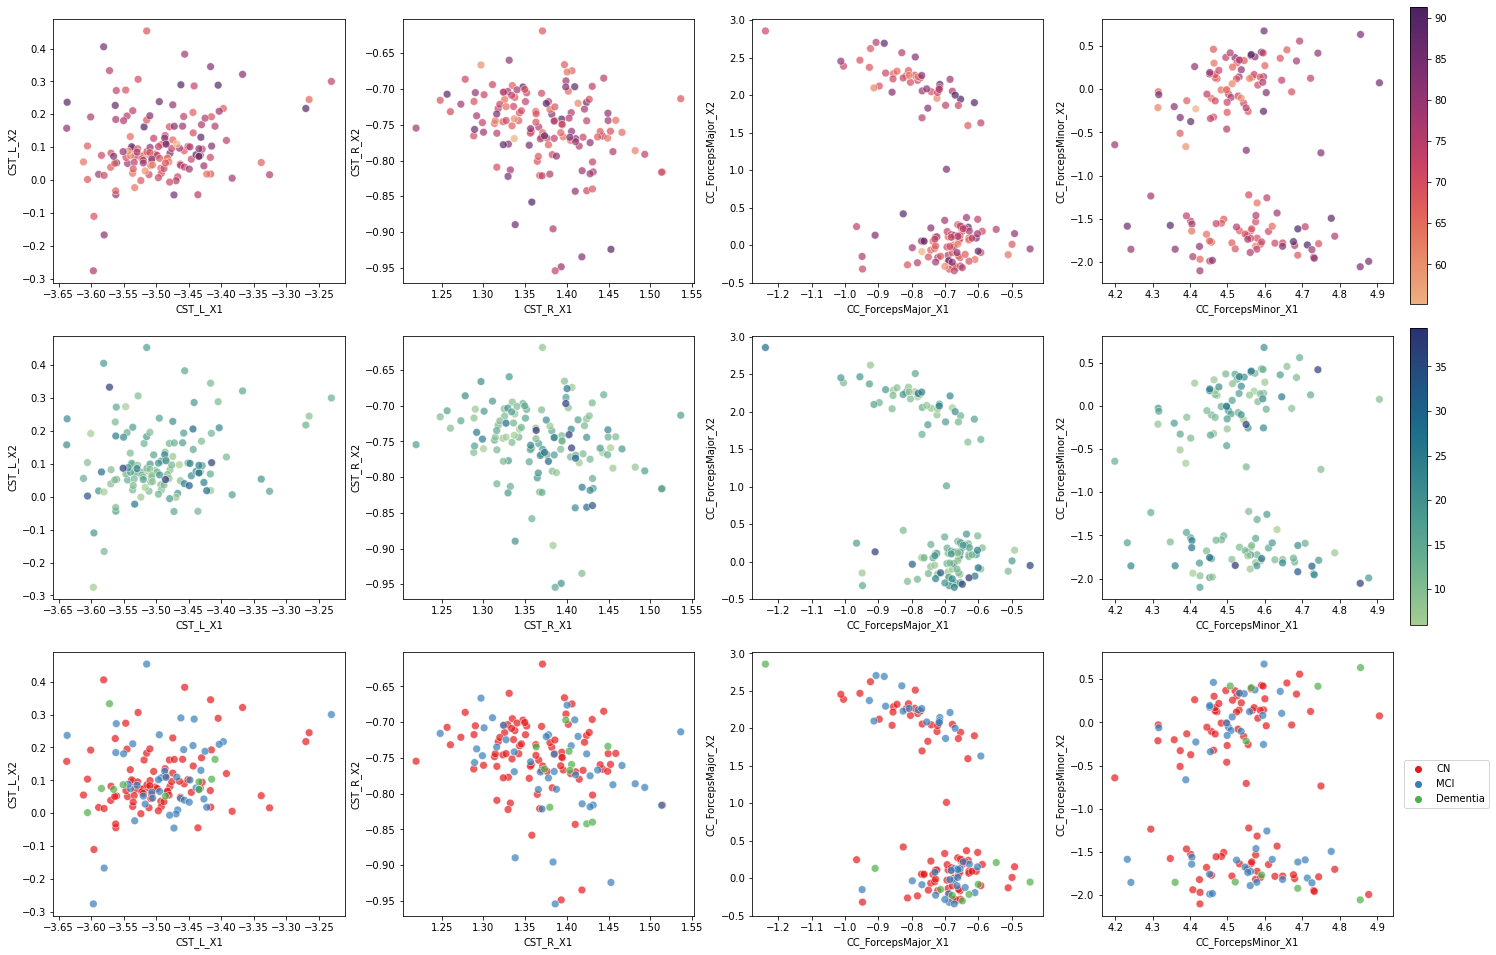

In [418]:
# bundle_names = subj_cn1['bundle_count'].keys()
bundle_names=['CST_L','CST_R','CC_ForcepsMajor','CC_ForcepsMinor']
measures = ["Age",'ADAS13','DX']
palettes=['flare','crest','Set1']

fig, axes = plt.subplots(nrows=len(measures), ncols=len(bundle_names), 
                         figsize=(6*len(bundle_names), 5.5*len(measures)))

for i in range(len(measures)):  #row index
    value = measures[i]
    if value != 'DX' and j == len(bundle_names)-1:
        norm = plt.Normalize(df_meta[value].min(), df_meta[value].max())
        sm = plt.cm.ScalarMappable(cmap=palettes[i], norm=norm)
        sm.set_array([])
        if i == 0:
            cbar_ax = fig.add_axes([0.91, 0.64, 0.01, 0.25])
        elif i==1:
            cbar_ax = fig.add_axes([0.91, 0.37, 0.01, 0.25])
        fig.colorbar(sm, cax=cbar_ax)
#         axes[i][-1].figure.colorbar(sm)
    for j in range(len(bundle_names)):  # column index
        bundle = bundle_names[j]
        sns.scatterplot(data=df_meta, x=f"{bundle}_X1", y=f"{bundle}_X2", 
                    hue=value, palette=palettes[i], 
                    s=60, alpha=0.7, ax=axes[i][j])
        if value =="DX" and j==len(bundle_names)-1:
            axes[i][j].legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
        else:
            axes[i][j].get_legend().remove()

# fig.tight_layout()
        
# for bundle in bundle_names:
#     sns.scatterplot(data=df_meta, x=f"{bundle}_X1", y=f"{bundle}_X2", 
#                     hue=measure, palette='flare', 
#                     s=60, alpha=0.7, ax=ax)
# norm = plt.Normalize(df_meta[measure].min(), df_meta[measure].max())
# sm = plt.cm.ScalarMappable(cmap="crest", norm=norm)
# sm.set_array([])

# # Remove the legend and add a colorbar
# ax.get_legend().remove()
# ax.figure.colorbar(sm)

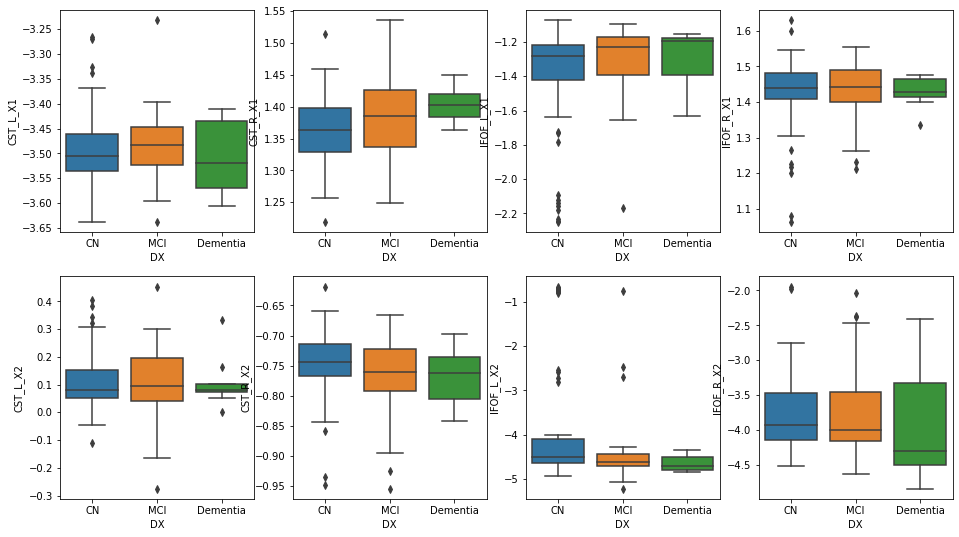

In [422]:
fig, axes = plt.subplots(nrows=2, ncols=4, 
                         figsize=(16, 9)) 
bundle_names=['CST_L','CST_R','IFOF_L','IFOF_R']

for i, bundle in enumerate(bundle_names):
    sns.boxplot(x="DX", y=f"{bundle}_X1", data=df_meta, ax=axes[0][i])
    sns.boxplot(x="DX", y=f"{bundle}_X2", data=df_meta, ax=axes[1][i])

## KNN Classification

In [438]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [155]:
'''Load training inference data'''
subj_train_data = load_inference(subj_train, model_subfolder, epoch)
df_meta['acc'] = np.nan

Loaded 007_S_6120_20171117_A3_DWI_S127 with 32 tracts and 51654 lines.


In [156]:
'''Train label encoder'''
le = LabelEncoder()
y_train = le.fit_transform(map_list_with_dict(subj_train_data['y'], 
                                            subj_train_data['bundle_num']))

In [157]:
'''Train KNN'''
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(subj_train_data['X_encoded'], y_train)

KNeighborsClassifier()

In [433]:
'''Training accuracy'''
def predict_bundle_knn(subj):
    y_new = le.transform(map_list_with_dict(subj['y'], subj['bundle_num']))

    y_pred = knn.predict(subj['X_encoded'])
    print(f"{accuracy_score(y_pred, y_new)}\n")
    return y_new, y_pred

def evaluate_clf(y, y_pred):
    print('Classification Report\n')
    print(classification_report(y, y_pred, target_names=le.classes_))
    
y_new, y_pred = predict_bundle_knn(subj_train_data)
# evaluate_clf(y_new, y_pred)

0.9580090602857475



In [452]:
'''Save accuracy for other subjects'''
total_acc = 0
nlines = 0
for subj in df_meta.Subject.values:
    subj_inferred = load_inference(subj, model_subfolder, epoch)
    y_new, y_pred = predict_bundle_knn(subj_inferred)

    # Get per class acc
    matrix = confusion_matrix(y_new, y_pred)
    acc_labels = zip(le.classes_, (matrix.diagonal()/matrix.sum(axis=1)))
    for label, accuracy in acc_labels:
        df_meta.at[df_meta.Subject==subj, f'{label}_acc'] = accuracy
    
    acc = accuracy_score(y_pred, y_new)
    total_acc += acc * len(y_new)
    nlines += len(y_new)
    df_meta.at[df_meta.Subject==subj, 'acc'] = acc
print(total_acc/nlines)
df_meta.to_csv(f"{data_files_folder}metadata_inference_acc.csv", index=False)

Loaded 002_S_0413_20190827_A3_DWI_S127 with 30 tracts and 21421 lines.
0.7619625601045703

Loaded 002_S_1280_20190306_A3_DWI_S127 with 28 tracts and 12032 lines.
0.7925531914893617



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 002_S_4213_20191003_A3_DWI_S127 with 32 tracts and 26093 lines.
0.7476334649139617

Loaded 002_S_6009_20190520_A3_DWI_S127 with 30 tracts and 33001 lines.
0.8138238235204994



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 002_S_6030_20190916_A3_DWI_S127 with 32 tracts and 43435 lines.
0.8299297801312305

Loaded 002_S_6053_20191105_A3_DWI_S127 with 31 tracts and 30773 lines.
0.8163324992688396



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 002_S_6066_20191111_A3_DWI_S127 with 31 tracts and 26055 lines.
0.8663980042218384

Loaded 002_S_6680_20190404_A3_DWI_S127 with 32 tracts and 35295 lines.
0.7992633517495396

Loaded 007_S_1222_20180117_A3_DWI_S127 with 31 tracts and 18720 lines.
0.8413461538461539

Loaded 007_S_4387_20171101_A3_DWI_S127 with 32 tracts and 28006 lines.
0.8007212740127115

Loaded 007_S_4488_20170912_A3_DWI_S127 with 31 tracts and 35087 lines.
0.8077350585687006

Loaded 007_S_4620_20171205_A3_DWI_S127 with 30 tracts and 23916 lines.
0.7727462786419134

Loaded 007_S_4637_20171010_A3_DWI_S127 with 30 tracts and 22384 lines.
0.817860972122945



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 007_S_5265_20170918_A3_DWI_S127 with 31 tracts and 22859 lines.
0.7512577103110373



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 007_S_6255_20180305_A3_DWI_S127 with 29 tracts and 21601 lines.
0.7726031202259155

Loaded 007_S_6310_20180409_A3_DWI_S127 with 29 tracts and 33199 lines.
0.8304768215910118

Loaded 007_S_6323_20180417_A3_DWI_S127 with 32 tracts and 43676 lines.
0.8389504533382178

Loaded 007_S_6455_20180619_A3_DWI_S127 with 31 tracts and 38790 lines.
0.7640113431296726

Loaded 007_S_6515_20180716_A3_DWI_S127 with 29 tracts and 29572 lines.
0.7801298525632355



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 007_S_6521_20180717_A3_DWI_S127 with 30 tracts and 32846 lines.
0.7626194970468245



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 022_S_6069_20191210_A3_DWI_S127 with 30 tracts and 30140 lines.
0.8438619774386198



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 022_S_6797_20190828_A3_DWI_S127 with 31 tracts and 36064 lines.
0.7812777284826974



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 022_S_6822_20191003_A3_DWI_S127 with 30 tracts and 27097 lines.
0.8048861497582758



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 023_S_0031_20190424_A3_DWI_S127 with 19 tracts and 7176 lines.
0.7596153846153846



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 023_S_4164_20171218_A3_DWI_S127 with 30 tracts and 27607 lines.
0.8173289383127468

Loaded 023_S_4448_20171204_A3_DWI_S127 with 31 tracts and 31741 lines.
0.8552345546769163

Loaded 023_S_6346_20180510_A3_DWI_S127 with 31 tracts and 45618 lines.
0.824236047174361

Loaded 023_S_6374_20180525_A3_DWI_S127 with 27 tracts and 26258 lines.
0.7668139233757331



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 023_S_6399_20180530_A3_DWI_S127 with 31 tracts and 39786 lines.
0.8104609661690042

Loaded 023_S_6400_20180530_A3_DWI_S127 with 32 tracts and 34521 lines.
0.8072767301063121

Loaded 023_S_6547_20180807_A3_DWI_S127 with 29 tracts and 40028 lines.
0.7786049765164385



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 023_S_6795_20190806_A3_DWI_S127 with 30 tracts and 40017 lines.
0.8001849214084015



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 024_S_4084_20190805_A3_DWI_S127 with 30 tracts and 32540 lines.
0.8274124154886294

Loaded 024_S_5290_20181031_A3_DWI_S127 with 31 tracts and 37335 lines.
0.8569974554707379

Loaded 024_S_6005_20190325_A3_DWI_S127 with 27 tracts and 22731 lines.
0.8099951607936299



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 024_S_6385_20190715_A3_DWI_S127 with 30 tracts and 27479 lines.
0.8630954547108701



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 024_S_6472_20180702_A3_DWI_S127 with 30 tracts and 33955 lines.
0.8163157119717273



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 036_S_4491_20180314_A3_DWI_S127 with 28 tracts and 29131 lines.
0.7718924856681886



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 036_S_6189_20180129_A3_DWI_S127 with 29 tracts and 48673 lines.
0.8202905101390915

Loaded 036_S_6316_20180426_A3_DWI_S127 with 30 tracts and 41704 lines.
0.8143103779014004

Loaded 037_S_4028_20191113_A3_DWI_S127 with 31 tracts and 33106 lines.
0.8027245816468314

Loaded 037_S_4214_20180926_A3_DWI_S127 with 25 tracts and 20819 lines.
0.7186704452663433



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 037_S_5126_20190923_A3_DWI_S127 with 28 tracts and 23755 lines.
0.7993264575878762



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 037_S_5222_20190923_A3_DWI_S127 with 31 tracts and 37192 lines.
0.8258765325876533

Loaded 037_S_6031_20191008_A3_DWI_S127 with 30 tracts and 38356 lines.
0.8264938992595683

Loaded 037_S_6125_20190325_A3_DWI_S127 with 29 tracts and 33744 lines.
0.7784198672356567



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 037_S_6187_20180314_A3_DWI_S127 with 29 tracts and 28329 lines.
0.7528327861908292



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 037_S_6204_20180309_A3_DWI_S127 with 31 tracts and 44300 lines.
0.8429571106094809



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 037_S_6271_20180517_A3_DWI_S127 with 31 tracts and 45869 lines.
0.7975539035078157

Loaded 052_S_6412_20180801_A3_DWI_S127 with 31 tracts and 32201 lines.
0.7771808328933884



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 067_S_2301_20170811_A3_DWI_S127 with 31 tracts and 38179 lines.
0.8173603289766626



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 067_S_4072_20170825_A3_DWI_S127 with 31 tracts and 32454 lines.
0.7798422382449005

Loaded 067_S_4184_20171120_A3_DWI_S127 with 29 tracts and 35006 lines.
0.8214877449580072



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 067_S_4212_20171120_A3_DWI_S127 with 30 tracts and 30985 lines.
0.7874778118444409



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 067_S_4767_20170605_A3_DWI_S127 with 30 tracts and 26951 lines.
0.7782271529813365

Loaded 067_S_6117_20171121_A3_DWI_S127 with 31 tracts and 33102 lines.
0.7633375626850342

Loaded 067_S_6138_20180608_A3_DWI_S127 with 31 tracts and 34099 lines.
0.8278835156456201

Loaded 067_S_6442_20180615_A3_DWI_S127 with 29 tracts and 25692 lines.
0.7795033473454772



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 067_S_6443_20180615_A3_DWI_S127 with 30 tracts and 23012 lines.
0.8014948722405701



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 067_S_6528_20180808_A3_DWI_S127 with 30 tracts and 43904 lines.
0.8417684037900874

Loaded 094_S_6485_20180719_A3_DWI_S127 with 30 tracts and 37497 lines.
0.8507880630450436

Loaded 128_S_0205_20180717_A3_DWI_S127 with 31 tracts and 37125 lines.
0.7831649831649832



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 341_S_6494_20180723_A3_DWI_S127 with 32 tracts and 37919 lines.
0.8315356417627047

Loaded 341_S_6653_20181219_A3_DWI_S127 with 31 tracts and 32905 lines.
0.831423795775718

Loaded 941_S_1195_20180405_A3_DWI_S127 with 28 tracts and 23724 lines.
0.7506744225257124



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 941_S_4187_20190625_A3_DWI_S127 with 29 tracts and 40815 lines.
0.7812568908489526

Loaded 941_S_4292_20190724_A3_DWI_S127 with 32 tracts and 24457 lines.
0.8411088849818048

Loaded 941_S_4376_20180815_A3_DWI_S127 with 30 tracts and 24494 lines.
0.764962848044419



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 941_S_5124_20180126_A3_DWI_S127 with 25 tracts and 18986 lines.
0.778837037817339



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 941_S_6054_20190729_A3_DWI_S127 with 28 tracts and 26601 lines.
0.8379384233675425



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 941_S_6058_20190814_A3_DWI_S127 with 29 tracts and 41120 lines.
0.8470573929961089



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 941_S_6080_20191104_A3_DWI_S127 with 31 tracts and 28262 lines.
0.7675323756280518



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 941_S_6094_20191113_A3_DWI_S127 with 30 tracts and 27356 lines.
0.8054540137446995

Loaded 941_S_6254_20190515_A3_DWI_S127 with 30 tracts and 34966 lines.
0.7982039695704398



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 941_S_6384_20180530_A3_DWI_S127 with 31 tracts and 42921 lines.
0.8545234267607931

Loaded 941_S_6422_20180613_A3_DWI_S127 with 32 tracts and 32917 lines.
0.779050338730747

Loaded 941_S_6454_20180627_A3_DWI_S127 with 31 tracts and 33804 lines.
0.769938468820258

Loaded 941_S_6471_20180702_A3_DWI_S127 with 28 tracts and 37373 lines.
0.7941562090279078



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 941_S_6495_20180717_A3_DWI_S127 with 26 tracts and 16945 lines.
0.8116258483328416



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 941_S_6496_20180717_A3_DWI_S127 with 31 tracts and 26018 lines.
0.7725036513183181



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 941_S_6499_20180717_A3_DWI_S127 with 31 tracts and 21387 lines.
0.8546780754664048

Loaded 941_S_6570_20180831_A3_DWI_S127 with 31 tracts and 41923 lines.
0.8243446318250125



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 941_S_6574_20180907_A3_DWI_S127 with 28 tracts and 28574 lines.
0.8412542871141597

Loaded 941_S_6575_20180905_A3_DWI_S127 with 30 tracts and 24148 lines.
0.764204074871625

Loaded 941_S_6580_20180907_A3_DWI_S127 with 25 tracts and 10157 lines.
0.7717830067933444



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 941_S_6581_20180912_A3_DWI_S127 with 30 tracts and 34765 lines.
0.7934992089745434

Loaded 002_S_6652_20181213_A3_DWI_S127 with 30 tracts and 23410 lines.
0.756984194788552



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 007_S_2394_20170814_A3_DWI_S127 with 30 tracts and 31989 lines.
0.7562287036168683



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 007_S_4272_20180116_A3_DWI_S127 with 29 tracts and 21836 lines.
0.7314526470049459



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 007_S_6341_20180430_A3_DWI_S127 with 31 tracts and 30421 lines.
0.8344893330265277

Loaded 007_S_6421_20180605_A3_DWI_S127 with 30 tracts and 31247 lines.
0.7897078119499472



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 023_S_2068_20171215_A3_DWI_S127 with 31 tracts and 19641 lines.
0.77007280688356

Loaded 023_S_4115_20180124_A3_DWI_S127 with 32 tracts and 25791 lines.
0.7935326276608119

Loaded 023_S_6334_20180504_A3_DWI_S127 with 31 tracts and 39898 lines.
0.8105920096245426



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 023_S_6356_20180529_A3_DWI_S127 with 29 tracts and 35237 lines.
0.7746402928739677

Loaded 023_S_6369_20180518_A3_DWI_S127 with 30 tracts and 27293 lines.
0.7535631846993734



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 023_S_6535_20180802_A3_DWI_S127 with 30 tracts and 22938 lines.
0.7782718632836342



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 023_S_6702_20190312_A3_DWI_S127 with 32 tracts and 34621 lines.
0.8889402385835187

Loaded 023_S_6723_20190419_A3_DWI_S127 with 31 tracts and 32974 lines.
0.8152787044337964

Loaded 024_S_4674_20190624_A3_DWI_S127 with 32 tracts and 33649 lines.
0.8465630479360456

Loaded 024_S_6033_20190710_A3_DWI_S127 with 29 tracts and 40290 lines.
0.8319682303301067



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 036_S_2380_20180618_A3_DWI_S127 with 27 tracts and 42679 lines.
0.7523372150237821

Loaded 036_S_2380_20190605_A3_DWI_S127 with 28 tracts and 16973 lines.
0.7579096211630236



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 037_S_0377_20180314_A3_DWI_S127 with 20 tracts and 11856 lines.
0.717948717948718



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 037_S_4706_20191216_A3_DWI_S127 with 32 tracts and 30905 lines.
0.8046917974437793

Loaded 037_S_6083_20181107_A3_DWI_S127 with 30 tracts and 26019 lines.
0.7489526884200007



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 037_S_6141_20190322_A3_DWI_S127 with 30 tracts and 30952 lines.
0.7730356681313001

Loaded 037_S_6222_20180530_A3_DWI_S127 with 29 tracts and 17620 lines.
0.76577752553916



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 037_S_6620_20181126_A3_DWI_S127 with 31 tracts and 42335 lines.
0.8439588992559348



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 037_S_6627_20181130_A3_DWI_S127 with 30 tracts and 26868 lines.
0.7815989280928987



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 051_S_5285_20181002_A3_DWI_S127 with 24 tracts and 25005 lines.
0.6944611077784443



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 051_S_6719_20190501_A3_DWI_S127 with 31 tracts and 32820 lines.
0.7813528336380255



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 051_S_6761_20190705_A3_DWI_S127 with 31 tracts and 33916 lines.
0.8025710579077722

Loaded 052_S_4944_20180420_A3_DWI_S127 with 31 tracts and 27152 lines.
0.7941219799646435

Loaded 052_S_6832_20191115_A3_DWI_S127 with 30 tracts and 11266 lines.
0.7725013314397302

Loaded 067_S_0056_20171128_A3_DWI_S127 with 31 tracts and 27469 lines.
0.8327205213149368

Loaded 067_S_0059_20171220_A3_DWI_S127 with 32 tracts and 31379 lines.
0.7939704898180312

Loaded 067_S_6474_20180627_A3_DWI_S127 with 29 tracts and 34612 lines.
0.7526580376747949

Loaded 067_S_6525_20190605_A3_DWI_S127 with 32 tracts and 39921 lines.
0.8195185491345407

Loaded 067_S_6529_20180814_A3_DWI_S127 with 31 tracts and 43086 lines.
0.7813674975630135

Loaded 128_S_4742_20180821_A3_DWI_S127 with 29 tracts and 18336 lines.
0.7616164921465969



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 341_S_6605_20181017_A3_DWI_S127 with 30 tracts and 34366 lines.
0.7638072513530816

Loaded 341_S_6686_20190220_A3_DWI_S127 with 30 tracts and 26314 lines.
0.7405943604165083



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 341_S_6764_20190716_A3_DWI_S127 with 31 tracts and 29888 lines.
0.7801458779443254



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 941_S_4036_20181120_A3_DWI_S127 with 28 tracts and 36038 lines.
0.7803152228203563



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 941_S_4100_20181119_A3_DWI_S127 with 20 tracts and 9904 lines.
0.6948707592891761



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 941_S_6052_20180706_A3_DWI_S127 with 19 tracts and 11533 lines.
0.7486343535940345



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 941_S_6068_20180817_A3_DWI_S127 with 30 tracts and 24987 lines.
0.8102613358946652



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 941_S_6345_20180510_A3_DWI_S127 with 30 tracts and 24715 lines.
0.7724054218086183

Loaded 941_S_6392_20180530_A3_DWI_S127 with 31 tracts and 31811 lines.
0.754047342114363



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 022_S_6796_20190903_A3_DWI_S127 with 29 tracts and 15639 lines.
0.7325915979282562



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 023_S_1190_20190225_A3_DWI_S127 with 31 tracts and 30069 lines.
0.801456649705677



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 023_S_6661_20190107_A3_DWI_S127 with 28 tracts and 30139 lines.
0.7375161750555759



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 036_S_6179_20190507_A3_DWI_S127 with 27 tracts and 11674 lines.
0.7796813431557307



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 036_S_6231_20180305_A3_DWI_S127 with 29 tracts and 26566 lines.
0.820673040728751



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 037_S_4030_20180910_A3_DWI_S127 with 27 tracts and 19683 lines.
0.7685312198343749



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 037_S_6216_20180503_A3_DWI_S127 with 29 tracts and 24616 lines.
0.7363097172570686



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 037_S_6230_20180601_A3_DWI_S127 with 26 tracts and 26729 lines.
0.6833401923004976



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 037_S_6377_20180706_A3_DWI_S127 with 30 tracts and 22385 lines.
0.743801652892562



/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Loaded 341_S_6820_20190925_A3_DWI_S127 with 28 tracts and 20858 lines.
0.7746667945152939

0.7970274741810087


/Users/wendy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [161]:
'''Get accuracy for each DX'''
dx_ls = ['CN','MCI','Dementia']
for dx in dx_ls:
    df_selected = df_meta[df_meta.DX==dx]
    print((df_selected.acc * df_selected.streamline_count).sum() / (df_selected.streamline_count.sum()))

0.8055510061878018
0.7859212754401099
0.7576393207157183


<AxesSubplot:ylabel='acc'>

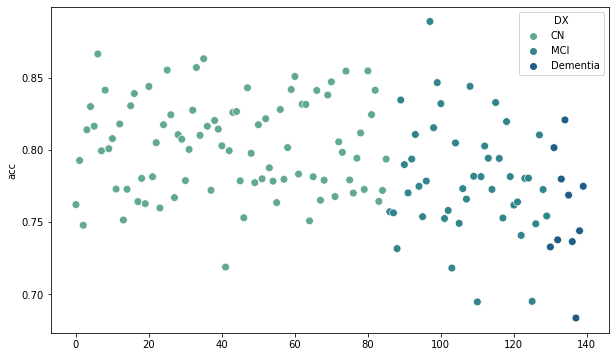

In [319]:
'''Plot accuracy colored by specified measure'''

fig, ax = plt.subplots(1, figsize=(10, 6))
measure = 'DX'
sns.scatterplot(data=df_meta, x=df_meta.index, y='acc', hue=measure, palette='crest', s=60, ax=ax)

# ## Set colorbar range
# norm = plt.Normalize(df_meta[measure].min(), df_meta[measure].max())
# sm = plt.cm.ScalarMappable(cmap="crest", norm=norm)
# sm.set_array([])

# # Remove the legend and add a colorbar
# ax.get_legend().remove()
# ax.figure.colorbar(sm)

In [40]:
row_colors

0      (0.9, 0.14799999999999996, 0.09999999999999998)
1      (0.9, 0.14799999999999996, 0.09999999999999998)
2      (0.9, 0.14799999999999996, 0.09999999999999998)
3      (0.9, 0.14799999999999996, 0.09999999999999998)
4      (0.9, 0.14799999999999996, 0.09999999999999998)
                            ...                       
135    (0.09999999999999998, 0.9, 0.14800000000000002)
136    (0.09999999999999998, 0.9, 0.14800000000000002)
137    (0.09999999999999998, 0.9, 0.14800000000000002)
138    (0.09999999999999998, 0.9, 0.14800000000000002)
139    (0.09999999999999998, 0.9, 0.14800000000000002)
Name: DX, Length: 140, dtype: object

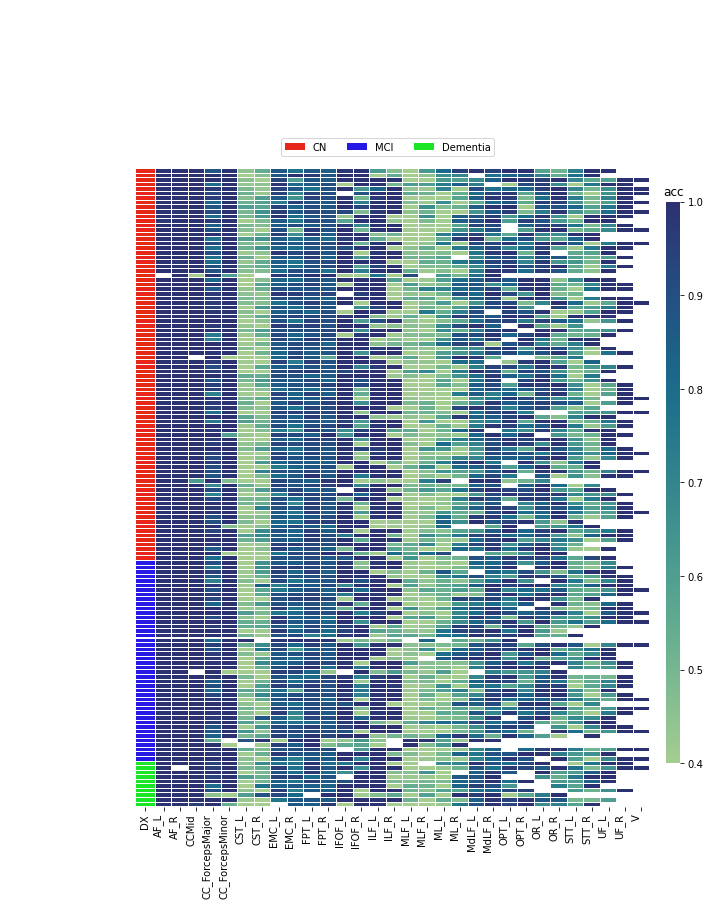

In [43]:
idx = [i.endswith("acc") and not i.endswith("_s_acc") \
       and not i.startswith("acc") for i in df_meta.columns.values]
df_plot = df_meta.loc[:, idx]

# df_meta.DX_num = map_list_with_dict(df_meta.DX, {"CN":0,'MCI':1,'Dementia':2})
labels = df_meta.DX
lut = dict(zip(set(labels), sns.hls_palette(len(set(labels)), l=0.5, s=0.8)))
row_colors = pd.Series(labels).map(lut)

cg = sns.clustermap(df_plot, figsize=(10, 13), 
                    cmap = "crest", linewidth = 0.005, 
                    yticklabels=df_meta.DX, row_colors = row_colors,
                    cbar_pos=(.93, .18, .02, .6),
                    vmin=0.4, vmax=1.0,
                    row_cluster = False, col_cluster = False)

cg.cax.set_title("acc")
cg.ax_heatmap.yaxis.set_visible(False)
xtlabels = ["_".join(i.split("_")[:-1]) for i in df_plot.columns]
cg.ax_heatmap.set_xticklabels(xtlabels, rotation = 90, ha="right")

for label in labels.unique():
    cg.ax_col_dendrogram.bar(0, 0, color=lut[label],
                            label=label, linewidth=0)
cg.ax_col_dendrogram.legend(loc="center", ncol=8, 
                            bbox_to_anchor=(0.47, 0.12))

plt.show()
cg.savefig(plot_folder + "/acc_clustermap.pdf")

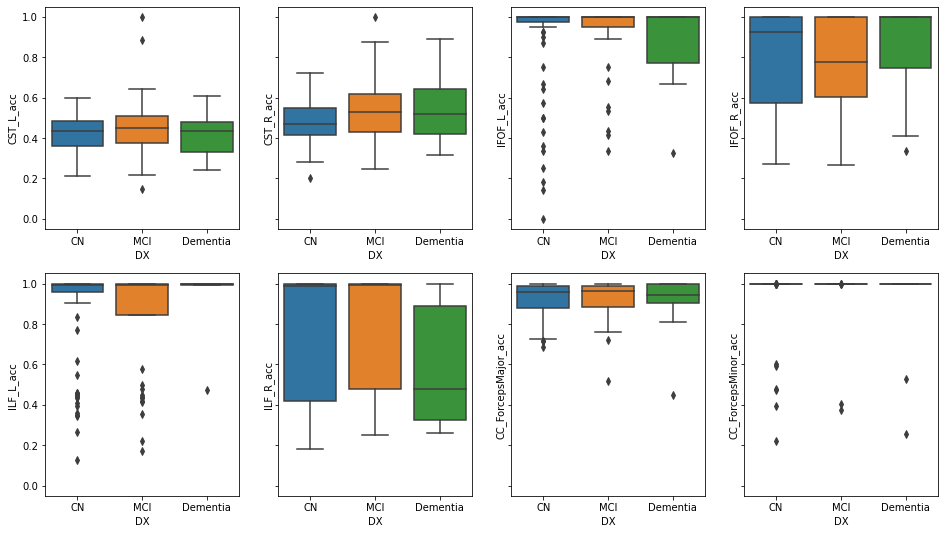

In [457]:
fig, axes = plt.subplots(nrows=2, ncols=4, 
                         figsize=(16, 9), sharey=True) 
bundle_names=['CST_L','CST_R','IFOF_L','IFOF_R',
              'ILF_L','ILF_R',
              'CC_ForcepsMajor', 'CC_ForcepsMinor']

for i, bundle in enumerate(bundle_names):
    sns.boxplot(x="DX", y=f"{bundle}_acc", data=df_meta, ax=axes.flatten()[i])

## Hierarchical Clustering

In [344]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

In [345]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

2
Counter({1: 701, 0: 4})


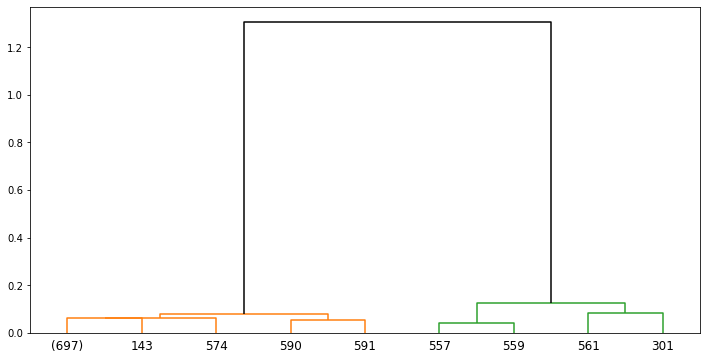

In [346]:
bundle_name = 'CST_R'
X_bundle = subj_cn1['X_encoded'][subj_cn1['bundle_idx'][bundle_name]]

clt = AgglomerativeClustering(distance_threshold=0.2, 
                              n_clusters=None,
                              linkage='single')
clt = clt.fit(X_bundle)
print(clt.n_clusters_)
print(Counter(clt.labels_))

fig, ax = plt.subplots(1, figsize=(12, 6))
plot_dendrogram(clt, truncate_mode="level", p=3,
                above_threshold_color='k',
                ax=ax)

In [349]:
def select_lines(lines, n_lines=5):
    idx = np.random.choice(len(lines), n_lines, replace=False)
    return lines[idx]

In [350]:
color_list = mpl.cm.datad['tab10']['listed']
scene = window.Scene()

n_lines = 50

# for i in Counter(clt.labels_):
i=0
idx = (clt.labels_==i)
lines = subj_cn1['X'][subj_cn1['bundle_idx'][bundle_name]][idx]
print(len(lines))
# lines = select_lines(lines, n_lines)
scene.add(actor.streamtube(lines, linewidth=0.1, colors=color_list[i]))

i=1
idx = (clt.labels_==i)
lines = subj_cn1['X'][subj_cn1['bundle_idx'][bundle_name]][idx]
print(len(lines))
lines = select_lines(lines, 10)
scene.add(actor.streamtube(lines, linewidth=0.1, colors=color_list[i]))

window.show(scene, size=(1000,1000), reset_camera=False)

4
701


# Visualization

## Reconstruction

### Multiple subjects, selected bundles

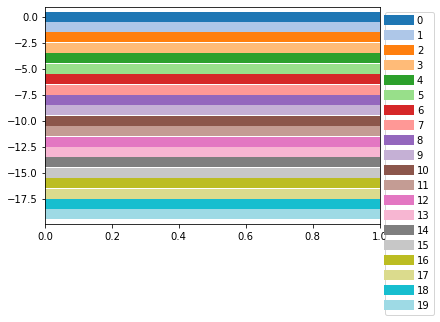

In [44]:
bundles_vis = ['FPT_L','CST_L']
color_list = mpl.cm.datad['tab20']['listed']

for i, _ in enumerate(color_list):
    plt.axhline(-i, linewidth=10, c=color_list[i], label=i)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

In [45]:
'''visualize orig streamlines'''
scene = window.Scene()

for i, subj in enumerate([subj_cn1, subj_mci, subj_ad]):
    for j, bundle in enumerate(bundles_vis):
        lines = subj['X'][subj['bundle_idx'][bundle]]
        scene.add(actor.streamtube(lines, linewidth=0.1, colors=color_list[i]))

window.show(scene, size=(1000,1000), reset_camera=False)

In [35]:
'''visualize reconstructed streamlines'''
scene = window.Scene()

for i, subj in enumerate([subj_cn1, subj_ad]):
    for j, bundle in enumerate(bundles_vis):
        lines = subj['X_recon'][subj['bundle_idx'][bundle]]
        scene.add(actor.streamtube(lines, linewidth=0.1, colors=color_list[i]))

window.show(scene, size=(1000,1000), reset_camera=False)

In [37]:
'''visualize orig with reconstructed streamlines'''
scene = window.Scene()

bundle = 'CCMid'
subj = subj_ad
lines_orig = subj['X'][subj['bundle_idx'][bundle]]
scene.add(actor.streamtube(lines_orig, linewidth=0.1, colors=color_list[0]))
lines_recon = subj['X_recon'][subj['bundle_idx'][bundle]]
scene.add(actor.streamtube(lines_recon, linewidth=0.1, colors=color_list[1]))

window.show(scene, size=(1000,1000), reset_camera=False)

### One subject multiple bundles

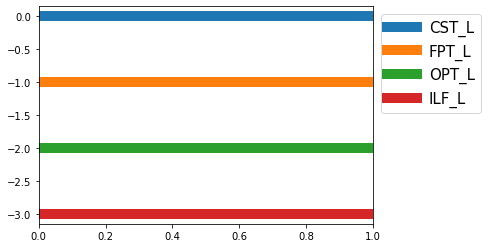

In [105]:
subj = subj_ad
label='ad'
bundles_vis = ['CST_L','FPT_L','OPT_L','ILF_L']
color_list = mpl.cm.datad['tab10']['listed']


for i, name in enumerate(bundles_vis):
    plt.axhline(-i, linewidth=10, c=color_list[i], label=name)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1,prop={'size': 15})

In [106]:
'''visualize streamlines'''
scene = window.Scene()
scene.set_camera(position=(-433.12, 20.27, -85.26), 
                 focal_point=(-14.58, -19.16, 4.18),
                 view_up=(-0.13, 0.52, 0.84))

for i, bundle in enumerate(bundles_vis):
    lines = subj['X'][subj['bundle_idx'][bundle]]
    scene.add(actor.streamtube(lines, linewidth=0.1, colors=color_list[i]))

# window.show(scene, size=(1000,1000), reset_camera=False)
window.record(scene, size=(1200, 1200), out_path=plot_folder+f"{label}_{len(bundles_vis)}bundle.png")

In [107]:
# scene.camera_info()

In [108]:
'''visualize reconstructed streamlines'''
scene = window.Scene()
scene.set_camera(position=(-433.12, 20.27, -85.26), 
                 focal_point=(-14.58, -19.16, 4.18),
                 view_up=(-0.13, 0.52, 0.84))

for i, bundle in enumerate(bundles_vis):
    lines = subj['X_recon'][subj['bundle_idx'][bundle]]
    scene.add(actor.streamtube(lines, linewidth=0.1, colors=color_list[i]))

# window.show(scene, size=(1000,1000), reset_camera=False)
window.record(scene, size=(1200, 1200), out_path=plot_folder+f"{label}_{len(bundles_vis)}bundle_recon.png")

## Randomly Generated

In [18]:
palette = mpl._color_data.CSS4_COLORS
mean = torch.tensor([1.1069, -23.8073,  13.3312])
std = torch.tensor([25.0185, 28.6887, 23.8379])

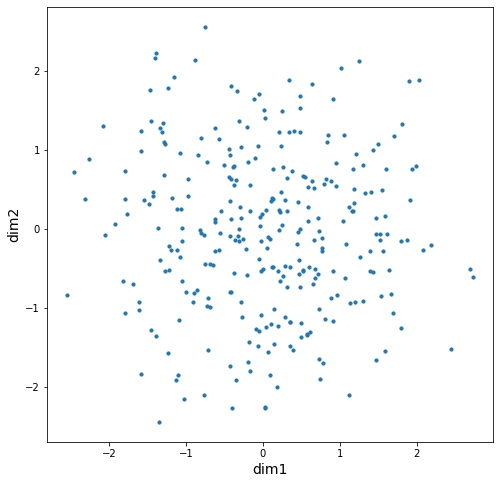

In [13]:
fig, ax = plt.subplots(1, figsize=(8, 8))
ax.set_xlabel('dim1', fontsize=14)
ax.set_ylabel('dim2', fontsize=14)

lines_gen, z = generate_samples(model, n_sample=300, ax=ax,
                             xl=None, xr=None, yl=None, yr=None,
                             mean=mean, std=std)

In [14]:
scene = window.Scene()

scene.set_camera(position=(412.30, -91.73, -16.43), 
                 focal_point=(4.04, -9.94, 6.81),
                 view_up=(0.20, 0.96, 0.18))

scene.add(actor.streamtube(lines_gen, linewidth=0.1, colors=mpl.colors.to_rgb(palette['white'])))

window.show(scene, size=(1000,1000), reset_camera=False)
# window.record(scene, size=(1200, 1200), out_path=plot_folder+"interp_random.png")

## Generated + Interpolation

In [19]:
palette = mpl._color_data.CSS4_COLORS
mean = torch.tensor([1.1069, -23.8073,  13.3312])
std = torch.tensor([25.0185, 28.6887, 23.8379])

In [39]:
from dipy.segment.metric import mdf

def _mdf_dist(lines, xmin=-5, xmax=5, plot_ax=True):
    dists = []
    for i in range(len(lines)-1):
        dists.append(mdf(lines[i], lines[i+1]))
    cum_dists = np.cumsum(dists)
    if plot_ax:
#         xrange = np.linspace(xmin, xmax, num=len(lines), endpoint=True)
        plot_ax.scatter(np.arange(len(cum_dists)), cum_dists, s=5)

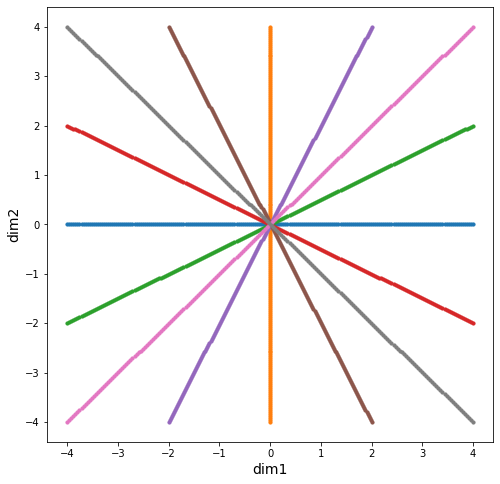

In [38]:
pos = 4
nsample=200

fig, ax = plt.subplots(1, figsize=(8, 8))
ax.set_xlabel('dim1', fontsize=14)
ax.set_ylabel('dim2', fontsize=14)

lines_gen1, _ = generate_samples(model, n_sample=nsample, ax=ax,
                                 xl=-pos, xr=pos, yl=0, yr=0,
                                 mean=mean, std=std)
lines_gen2, _ = generate_samples(model, n_sample=nsample, ax=ax,
                                 xl=0, xr=0, yl=-pos, yr=pos,
                                 mean=mean, std=std)

lines_gen5, _ = generate_samples(model, n_sample=nsample, ax=ax,
                                 xl=-pos, xr=pos, yl=-pos/2, yr=pos/2,
                                 mean=mean, std=std)
lines_gen6, _ = generate_samples(model, n_sample=nsample, ax=ax,
                                 xl=-pos, xr=pos, yl=pos/2, yr=-pos/2,
                                 mean=mean, std=std)
lines_gen7, _ = generate_samples(model, n_sample=nsample, ax=ax,
                                 xl=-pos/2, xr=pos/2, yl=-pos, yr=pos,
                                 mean=mean, std=std)
lines_gen8, _ = generate_samples(model, n_sample=nsample, ax=ax,
                                 xl=-pos/2, xr=pos/2, yl=pos, yr=-pos,
                                 mean=mean, std=std)

lines_gen9, _ = generate_samples(model, n_sample=200, ax=ax,
                                 xl=-pos, xr=pos, yl=-pos, yr=pos,
                                 mean=mean, std=std)
lines_gen10, _ = generate_samples(model, n_sample=200, ax=ax,
                                 xl=-pos, xr=pos, yl=pos, yr=-pos,
                                 mean=mean, std=std)

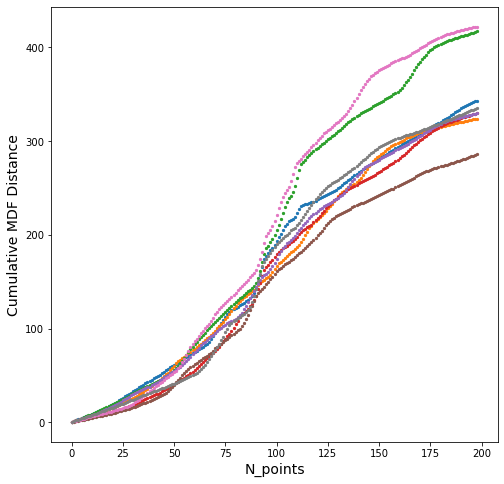

In [40]:
fig, ax = plt.subplots(1, figsize=(8, 8))
ax.set_xlabel('N_points', fontsize=14)
ax.set_ylabel('Cumulative MDF Distance', fontsize=14)

_mdf_dist(lines_gen1, xmin=-pos,xmax=pos, plot_ax=ax)
_mdf_dist(lines_gen2, xmin=-pos,xmax=pos, plot_ax=ax)
# _mdf_dist(lines_gen3, xmin=-pos,xmax=pos, plot_ax=ax)
# _mdf_dist(lines_gen4, xmin=-pos,xmax=pos, plot_ax=ax)
_mdf_dist(lines_gen5, xmin=-pos,xmax=pos, plot_ax=ax)
_mdf_dist(lines_gen6, xmin=-pos,xmax=pos, plot_ax=ax)
_mdf_dist(lines_gen7, xmin=-pos,xmax=pos, plot_ax=ax)
_mdf_dist(lines_gen8, xmin=-pos,xmax=pos, plot_ax=ax)
_mdf_dist(lines_gen9, xmin=-pos,xmax=pos, plot_ax=ax)
_mdf_dist(lines_gen10, xmin=-pos,xmax=pos, plot_ax=ax)


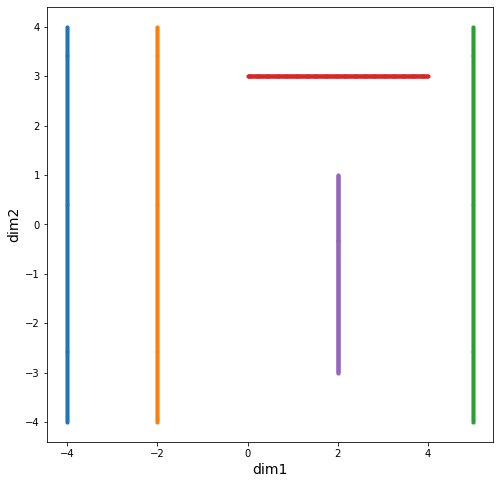

In [52]:
pos = 2

fig, ax = plt.subplots(1, figsize=(8, 8))
ax.set_xlabel('dim1', fontsize=14)
ax.set_ylabel('dim2', fontsize=14)

# left (blue, orange)
lines_gen1, _ = generate_samples(model, n_sample=nsample, ax=ax,
                                 xl=-4, xr=-4, yl=-4, yr=4,
                                 mean=mean, std=std)
lines_gen2, _ = generate_samples(model, n_sample=nsample, ax=ax,
                                 xl=-2, xr=-2, yl=-4, yr=4,
                                 mean=mean, std=std)

# mid (green, red)
lines_gen3, _ = generate_samples(model, n_sample=nsample, ax=ax,
                                 xl=5, xr=5, yl=-4, yr=4,
                                 mean=mean, std=std)
lines_gen4, _ = generate_samples(model, n_sample=nsample, ax=ax,
                                 xl=0, xr=4, yl=3, yr=3,
                                 mean=mean, std=std)


# right (purple)
lines_gen5, _ = generate_samples(model, n_sample=nsample, ax=ax,
                                 xl=2, xr=2, yl=-3, yr=1,
                                 mean=mean, std=std)

# # cross
# lines_gen6, _ = generate_samples(model, n_sample=nsample, ax=ax,
#                                  xl=-5, xr=5, yl=-5, yr=5,
#                                  mean=mean, std=std)

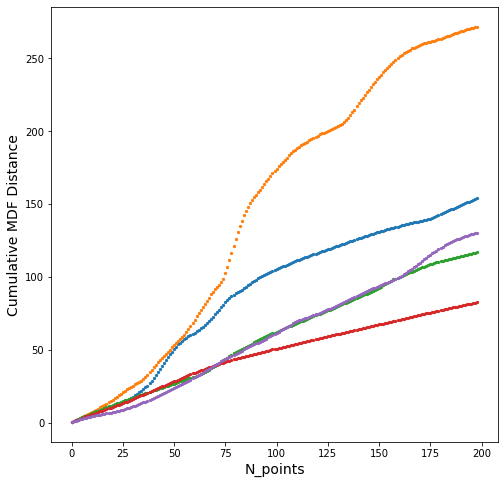

In [54]:
fig, ax = plt.subplots(1, figsize=(8, 8))
ax.set_xlabel('N_points', fontsize=14)
ax.set_ylabel('Cumulative MDF Distance', fontsize=14)

_mdf_dist(lines_gen1, xmin=-pos,xmax=pos, plot_ax=ax)
_mdf_dist(lines_gen2, xmin=-pos,xmax=pos, plot_ax=ax)
_mdf_dist(lines_gen3, xmin=-pos,xmax=pos, plot_ax=ax)
_mdf_dist(lines_gen4, xmin=-pos,xmax=pos, plot_ax=ax)
_mdf_dist(lines_gen5, xmin=-pos,xmax=pos, plot_ax=ax)

In [55]:
'''visualize generated streamlines'''
scene = window.Scene()

scene.set_camera(position=(-433.12, 20.27, -85.26), 
                 focal_point=(-14.58, -19.16, 4.18),
                 view_up=(-0.13, 0.52, 0.84))

scene.add(actor.streamtube(lines_gen1, linewidth=0.3, colors=mpl.colors.to_rgb(palette['blue'])))
scene.add(actor.streamtube(lines_gen2, linewidth=0.3, colors=mpl.colors.to_rgb(palette['orange'])))
scene.add(actor.streamtube(lines_gen3, linewidth=0.3, colors=mpl.colors.to_rgb(palette['green'])))
scene.add(actor.streamtube(lines_gen4, linewidth=0.3, colors=mpl.colors.to_rgb(palette['red'])))
scene.add(actor.streamtube(lines_gen5, linewidth=0.3, colors=mpl.colors.to_rgb(palette['purple'])))
# window.record(scene, size=(1200, 1200), out_path=plot_folder+"interp_12.png")

window.show(scene, size=(1000,1000), reset_camera=False)

In [42]:
'''visualize generated streamlines'''
scene = window.Scene()

# scene.set_camera(position=(412.30, -91.73, -16.43), 
#                  focal_point=(4.04, -9.94, 6.81),
#                  view_up=(0.20, 0.96, 0.18))
scene.set_camera(position=(-433.12, 20.27, -85.26), 
                 focal_point=(-14.58, -19.16, 4.18),
                 view_up=(-0.13, 0.52, 0.84))

scene.add(actor.streamtube(lines_gen9, linewidth=0.3, colors=mpl.colors.to_rgb(palette['pink'])))
scene.add(actor.streamtube(lines_gen10, linewidth=0.3, colors=mpl.colors.to_rgb(palette['grey'])))

window.show(scene, size=(1000,1000), reset_camera=False)
# window.record(scene, size=(1200, 1200), out_path=plot_folder+"interp_pink_grey.png")